In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch as tr
import numpy as np
import torchvision

import matplotlib.pyplot as plt
from PIL import Image

from src.model import load_model, load_chess, chess_preprocessing
from src.explaining import explain
from src.data import load_data, data2img, ToPIL, immono

In [3]:
# PubMedClip

model, preprocess = load_model('src/weights/PubMedClip_RN50_.pth')
features = tr.nn.Sequential(*list(model.visual.children())[:-1], tr.nn.AvgPool2d(7), tr.nn.Flatten())

In [4]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x313369300>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [5]:
# # CheSS

# model = load_chess('src/weights/chess.pth.tar')
# features = tr.nn.Sequential(*list(model.children())[:-1], tr.nn.Flatten())
# preprocess = chess_preprocessing

In [6]:
class Sum(tr.nn.Module):
    def forward(self, x):
        return x.sum()
transform = torchvision.transforms.Compose((ToPIL, preprocess))
train_dataset, test_dataset = load_data(transform=transform)
f = tr.nn.Sequential(features, Sum())
_, R = explain(train_dataset[1][0]['img'].unsqueeze(0), f)

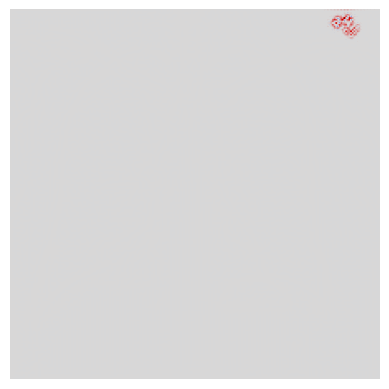

In [7]:
immono(R.sum(1).squeeze().data.numpy())

In [8]:
transform = torchvision.transforms.Compose((ToPIL, preprocess))
train_dataset, test_dataset = load_data(transform=transform)

In [9]:
def get_sample(i, dataset):
    data, label = dataset[i]
    x = data['img']
    y = label
    return x, y

Xtrain, ytrain = [], []
Xtest, ytest = [], []

for i in range(len(train_dataset)):
    x, y = get_sample(i, train_dataset)
    Xtrain += [x]
    ytrain += [y]
Xtrain = tr.stack(Xtrain)
ytrain = tr.tensor(ytrain)

for i in range(len(test_dataset)):
    x, y = get_sample(i, test_dataset)
    Xtest += [x]
    ytest += [y]
Xtest = tr.stack(Xtest)
ytest = tr.tensor(ytest)

In [10]:
print('train positive: %d train negative: %d'%(sum(ytrain == 1).item(), sum(ytrain == 0).item()))
print('test positive: %d test negative: %d'%(sum(ytest == 1).item(), sum(ytest == 0).item()))

train positive: 272 train negative: 2720
test positive: 70 test negative: 70


In [11]:
print('#nih train', len(train_dataset.nih_indices), "#github train", len(train_dataset.covid_indices))
print('#nih test', len(test_dataset.nih_indices), "#github test", len(test_dataset.covid_indices))

#nih train 2552 #github train 440
#nih test 45 #github test 95


In [12]:
print('NIH')
print('total images: ', len(train_dataset.nih_indices) + len(test_dataset.nih_indices))
print()

print('github')
print('total images: ', len(train_dataset.covid_indices) + len(test_dataset.covid_indices))
print('total covid: %d'%(sum(ytrain) + sum(ytest)))
print('total non-covid: %d'%(len(train_dataset.covid_indices) + len(test_dataset.covid_indices) - (sum(ytrain) + sum(ytest))))
print('non-covid train: %d'%(len(train_dataset.covid_indices) - sum(ytrain)))

NIH
total images:  2597

github
total images:  535
total covid: 342
total non-covid: 193
non-covid train: 168


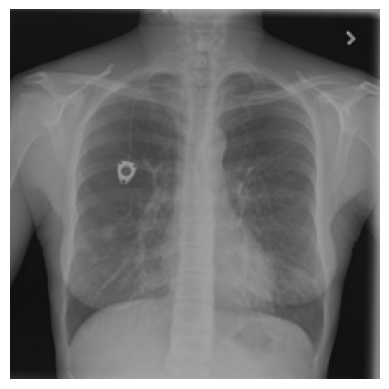

In [13]:
immono(data2img(Xtrain[0]), cmap='gray')

In [14]:
# takes ~3min.
with tr.no_grad():
    Ztrain = features(Xtrain)
    Ztest = features(Xtest)

In [12]:
# Ztrain_orig = Ztrain.clone()
# Ztest_orig = Ztest.clone()

In [13]:
# Ztrain = Ztrain_orig / Ztrain_orig.norm(dim=-1, keepdim=True)
# Ztest = Ztest_orig / Ztest_orig.norm(dim=-1, keepdim=True)

In [14]:
# Ztrain_orig.norm(dim=-1)

In [15]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# V = TSNE(n_components=2, perplexity=50, random_state=42).fit_transform(tr.cat([Ztrain, Ztest]))
V = PCA(n_components=2).fit_transform(tr.cat([Ztrain, Ztest]))

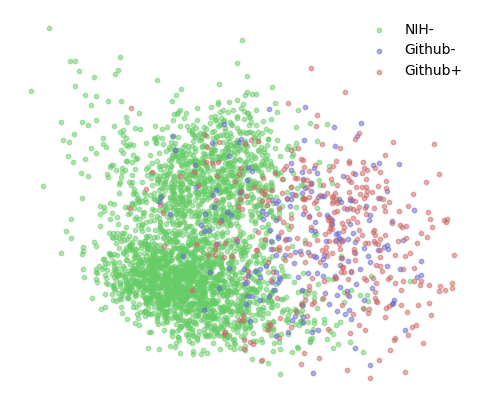

In [16]:
conditions = tr.zeros(len(V))
# kinda redundant
conditions[:len(train_dataset.nih_indices)] = 0
conditions[len(train_dataset):len(train_dataset)+len(test_dataset.nih_indices)] = 0
# covid negatives + positives
conditions[len(train_dataset.nih_indices):len(train_dataset)] = 1
conditions[len(train_dataset)+len(test_dataset.nih_indices):] = 1
# covid positives
conditions[tr.cat([ytrain, ytest]) == 1] = 2

plt.figure(figsize=(6,5))
plt.scatter(*V[conditions == 0].T, s=10, label='NIH-', c=(0.4, 0.8, 0.4), alpha=.5)
plt.scatter(*V[conditions == 1].T, s=10, label='Github-', c=(0.4, 0.4, 0.8), alpha=.5)
plt.scatter(*V[conditions == 2].T, s=10, label='Github+', c=(0.8, 0.4, 0.4), alpha=.5)
plt.legend(frameon=False)
plt.xticks([]), plt.yticks([])
plt.axis('off')
# plt.savefig('imgs/tsne_xray.png', bbox_inches='tight', pad_inches=.01, dpi=300)
plt.show()

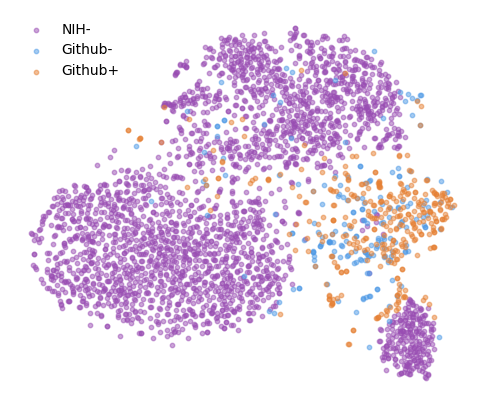

In [148]:
plt.figure(figsize=(6,5))
plt.scatter(*V[conditions == 0].T, s=10, label='NIH-', c=(0.6, 0.3, 0.7), alpha=.5)  # Purple
plt.scatter(*V[conditions == 1].T, s=10, label='Github-', c=(0.3, 0.6, 0.9), alpha=.5)  # Light Blue
plt.scatter(*V[conditions == 2].T, s=10, label='Github+', c=(0.9, 0.5, 0.2), alpha=.5)  # Orange
plt.legend(frameon=False)
plt.xticks([]), plt.yticks([])
plt.axis('off')
plt.savefig('imgs/tsne_xray_v1.png', bbox_inches='tight', pad_inches=.01, dpi=300)
plt.show()

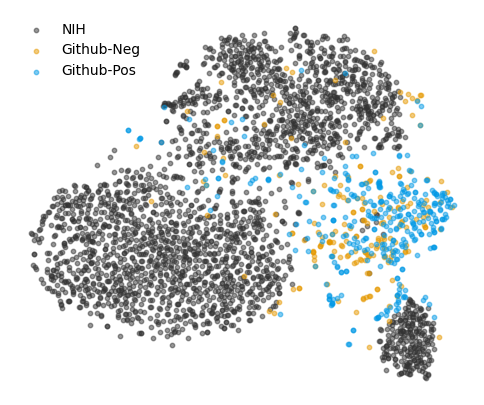

In [153]:
plt.figure(figsize=(6,5))
plt.scatter(*V[conditions == 0].T, s=10, label='NIH', c=(0.2, 0.2, 0.2), alpha=.5)  # Dark Grey
plt.scatter(*V[conditions == 1].T, s=10, label='Github-Neg', c=(0.9, 0.6, 0.0), alpha=.5)  # Yellow
plt.scatter(*V[conditions == 2].T, s=10, label='Github-Pos', c=(0.0, 0.6, 0.9), alpha=.5)  # Blue
plt.legend(frameon=False)
plt.xticks([]), plt.yticks([])
plt.axis('off')
plt.savefig('imgs/tsne_xray_v2.png', bbox_inches='tight', pad_inches=.01, dpi=300)
plt.show()

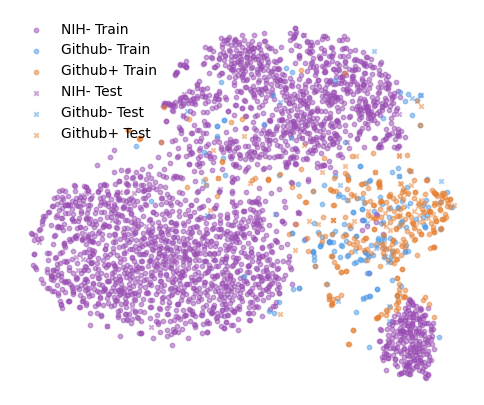

In [151]:
# Creating masks for training and test data
train_mask = tr.zeros(len(V), dtype=bool)
test_mask = tr.zeros(len(V), dtype=bool)
train_mask[:len(train_dataset)] = True
test_mask[len(train_dataset):] = True

# Scatter plot with different markers for training and test data
plt.figure(figsize=(6, 5))
plt.scatter(*V[(conditions == 0) & train_mask].T, s=10, label='NIH- Train', c=(0.6, 0.3, 0.7), alpha=.5, marker='o')  # Purple, circle
plt.scatter(*V[(conditions == 1) & train_mask].T, s=10, label='Github- Train', c=(0.3, 0.6, 0.9), alpha=.5, marker='o')  # Light Blue, circle
plt.scatter(*V[(conditions == 2) & train_mask].T, s=10, label='Github+ Train', c=(0.9, 0.5, 0.2), alpha=.5, marker='o')  # Orange, circle
plt.scatter(*V[(conditions == 0) & test_mask].T, s=10, label='NIH- Test', c=(0.6, 0.3, 0.7), alpha=.5, marker='x')  # Purple, x
plt.scatter(*V[(conditions == 1) & test_mask].T, s=10, label='Github- Test', c=(0.3, 0.6, 0.9), alpha=.5, marker='x')  # Light Blue, x
plt.scatter(*V[(conditions == 2) & test_mask].T, s=10, label='Github+ Test', c=(0.9, 0.5, 0.2), alpha=.5, marker='x')  # Orange, x
plt.legend(frameon=False)
plt.xticks([]), plt.yticks([])
plt.axis('off')
plt.savefig('imgs/tsne_xray_v3.png', bbox_inches='tight', pad_inches=.01, dpi=300)
plt.show()

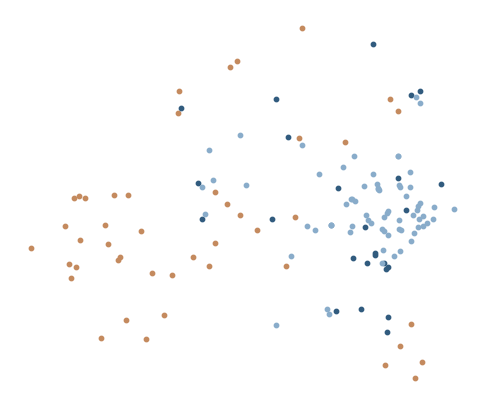

In [17]:
test_indices = list(range(len(train_dataset), len(train_dataset) + len(test_dataset)))

test_conditions = conditions[test_indices]
V_test = V[test_indices]

plt.figure(figsize=(6,5))
plt.scatter(*V_test[test_conditions == 0].T, s=10, label='NIH-', c=[196/255, 138/255, 94/255])
plt.scatter(*V_test[test_conditions == 1].T, s=10, label='Github-', c=[49/255, 91/255, 126/255])
plt.scatter(*V_test[test_conditions == 2].T, s=10, label='Github+', c=[137/255, 172/255, 202/255])
plt.xticks([]), plt.yticks([])
plt.axis('off')
plt.savefig('imgs/tsne_xray_test.png', bbox_inches='tight', pad_inches=.01, dpi=300)
plt.show()

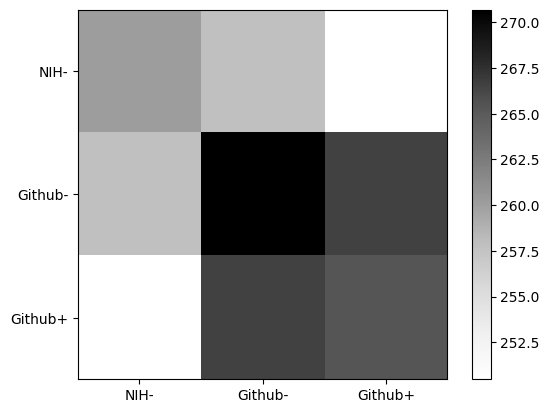

In [18]:
# compute dot-products between NIH Negatives / Github Negatives / Github Positives
Z = tr.cat([Ztrain, Ztest])
corr = tr.zeros(3, 3)
for i,I in enumerate([conditions == 0, conditions == 1, conditions == 2]):
    for j,J in enumerate([conditions == 0, conditions == 1, conditions == 2]):
        corr[i,j] = (Z[I] @ Z[J].T).mean()
plt.imshow(corr, cmap='Grays')
plt.colorbar()
plt.xticks([0, 1, 2], ['NIH-', 'Github-', 'Github+'])
plt.yticks([0, 1, 2], ['NIH-', 'Github-', 'Github+'])
plt.savefig('imgs/corr_xray.pdf', bbox_inches='tight')

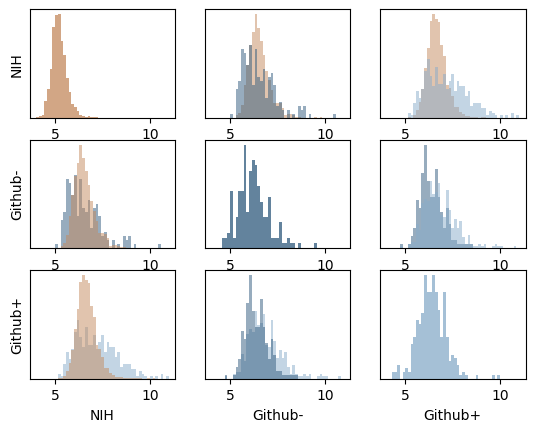

In [19]:
bins = np.linspace(4, 11, 50)
colors = {'NIH': (196/255, 138/255, 94/255), 'Github-': (49/255, 91/255, 126/255), 'Github+': (137/255, 172/255, 202/255)}
for i,(I,Ti) in enumerate(zip([conditions == 0, conditions == 1, conditions == 2], ['NIH', 'Github-', 'Github+'])):
    for j,(J,Tj) in enumerate(zip([conditions == 0, conditions == 1, conditions == 2], ['NIH', 'Github-', 'Github+'])):
        # corr = (Z[I] @ Z[J].T)
        corr = -tr.cdist(Z[I], Z[J])
        if i == j:
            corr.fill_diagonal_(-999)
        plt.subplot(3,3,(i)*3+j+1)
        #print(corr.max(1).values)
        plt.hist(-corr.max(1).values, bins=bins, density=True, label=Ti, alpha=.5, color=colors[Ti])
        plt.hist(-corr.max(0).values, bins=bins, density=True, label=Tj, alpha=.5, color=colors[Tj])
        #plt.ylim([0, 50])
        plt.yticks([])
        #plt.xticks([])
        #plt.legend()
        if j==0:
            plt.ylabel(Ti)
        if i==2:
            plt.xlabel(Tj)
plt.show()

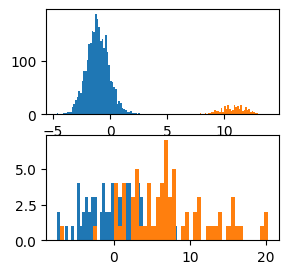

0.7857142857142857


In [114]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=1)
Vtrain = lda.fit_transform(Ztrain, ytrain)
Vtest = lda.transform(Ztest)

plt.figure(figsize=(3,3))
plt.subplot(211)
plt.hist(Vtrain[ytrain == 0], bins=50)
plt.hist(Vtrain[ytrain == 1], bins=50)
plt.subplot(212)
plt.hist(Vtest[ytest == 0], bins=50)
plt.hist(Vtest[ytest == 1], bins=50)
plt.show()

print(lda.score(Ztest, ytest))

In [20]:
from sklearn.svm import LinearSVC

clf = LinearSVC(C=.01, class_weight='balanced')
# clf = LinearSVC(C=.01)
clf.fit(Ztrain, ytrain)

print(clf.score(Ztrain, ytrain))
print(clf.score(Ztest, ytest))

0.9669117647058824
0.8785714285714286


In [21]:
W = tr.from_numpy(clf.coef_).float()
b = tr.from_numpy(clf.intercept_).float()
#W = tr.from_numpy(clf.best_estimator_.coef_).float()
#b = tr.from_numpy(clf.best_estimator_.intercept_).float()

linear = tr.nn.Linear(W.shape[1], 2)
linear.weight.data = tr.cat([-W, W])
linear.bias.data = tr.cat([-b, b])

# a Module is needed for zennit.composites.NameLayerMapComposite
class MyModule(tr.nn.Module):
    def __init__(self, features, clf_head, z=None):
        super().__init__()
        self.features = features
        self.clf_head = linear
        self.z = z

    def forward(self, x):
        x = self.features(x)
        x = self.clf_head(x)
        # x = x / x.norm().detach()
        # z = self.z / self.z.norm().detach()
        # x = x @ self.z
        return x

f = MyModule(features, linear)
print(f.z)

None


In [22]:
f(tr.zeros_like(Xtrain[[0]]))

tensor([[ 1.3048, -1.3048]], grad_fn=<AddmmBackward0>)

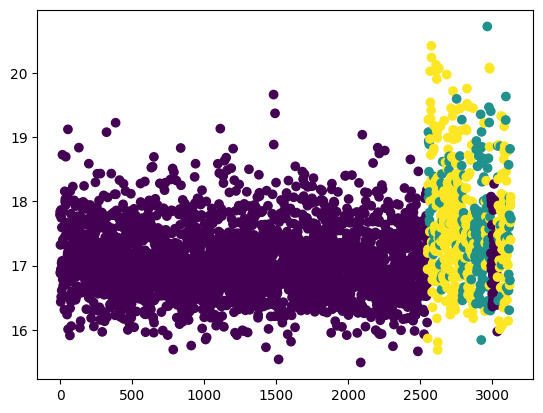

In [23]:
plt.scatter(list(range(len(Z))), Z.norm(dim=-1), c=conditions)

In [24]:
W[0] @ tr.ones_like(W[0]) / (W[0].norm() * tr.ones_like(W[0]).norm())

tensor(-0.0208)

Text(0, 0.5, '$w\\cdot x_i$')

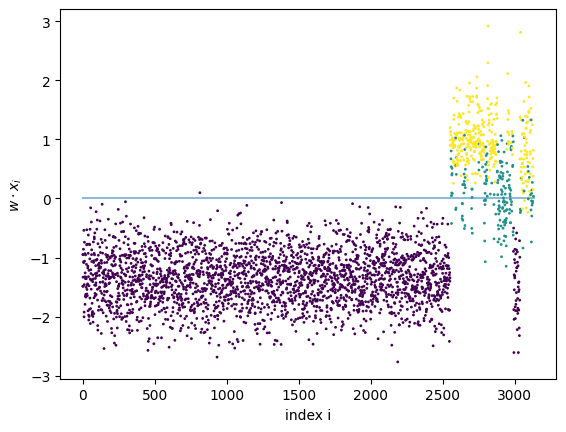

In [25]:
plt.scatter(list(range(len(Z))), Z @ W.T, c=conditions, s=1)
plt.plot([0, len(Z)], [0, 0], alpha=.5, zorder=-1) 
plt.xlabel('index i')
plt.ylabel('$w\cdot x_i$')

In [26]:
ypred = clf.decision_function(Ztest)
order = ypred.argsort()

In [27]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(
    ytest, ypred
)
F1_scores = np.divide(
    2 * precision * recall,
    precision + recall,
    out=np.zeros_like(precision),
    where=(precision + recall) != 0,
)

optimal_threshold = thresholds[np.argmax(F1_scores)]

In [28]:
optimal_threshold

0.09301641317421389

In [29]:
yhat = ypred > optimal_threshold

def attr_output(z):
    z = z + tr.tensor([optimal_threshold, -optimal_threshold])
    z[z < z.max()] = 0
    return z

def eqsp(arr, n):
    if n > len(arr):
        return arr
    step = len(arr) / n
    return [arr[int(i * step)] for i in range(n)]

Nvis = 5
Ipos = [i for i in order if i in ((yhat == ytest.numpy()) & (ytest.numpy() == 1)).nonzero()[0]]
Ineg = [i for i in order[::-1] if i in ((yhat == ytest.numpy()) & (ytest.numpy() == 0)).nonzero()[0]]

Ipos = eqsp(Ipos, Nvis)
Ineg = eqsp(Ineg, Nvis)

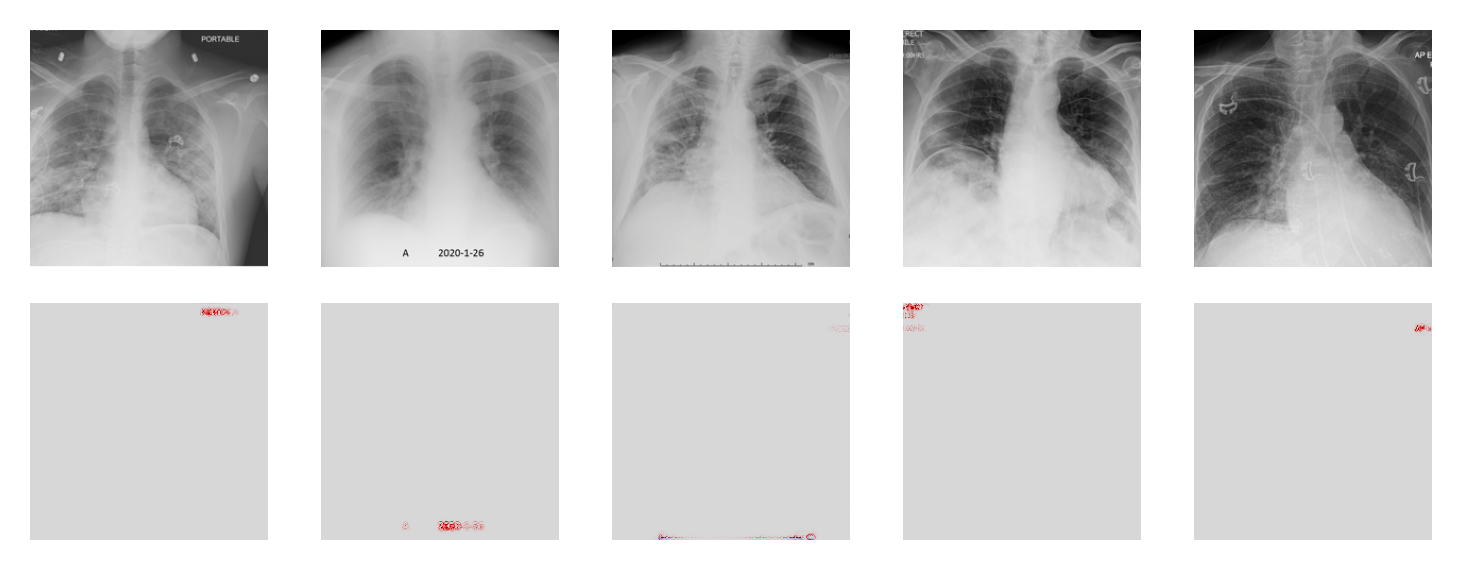

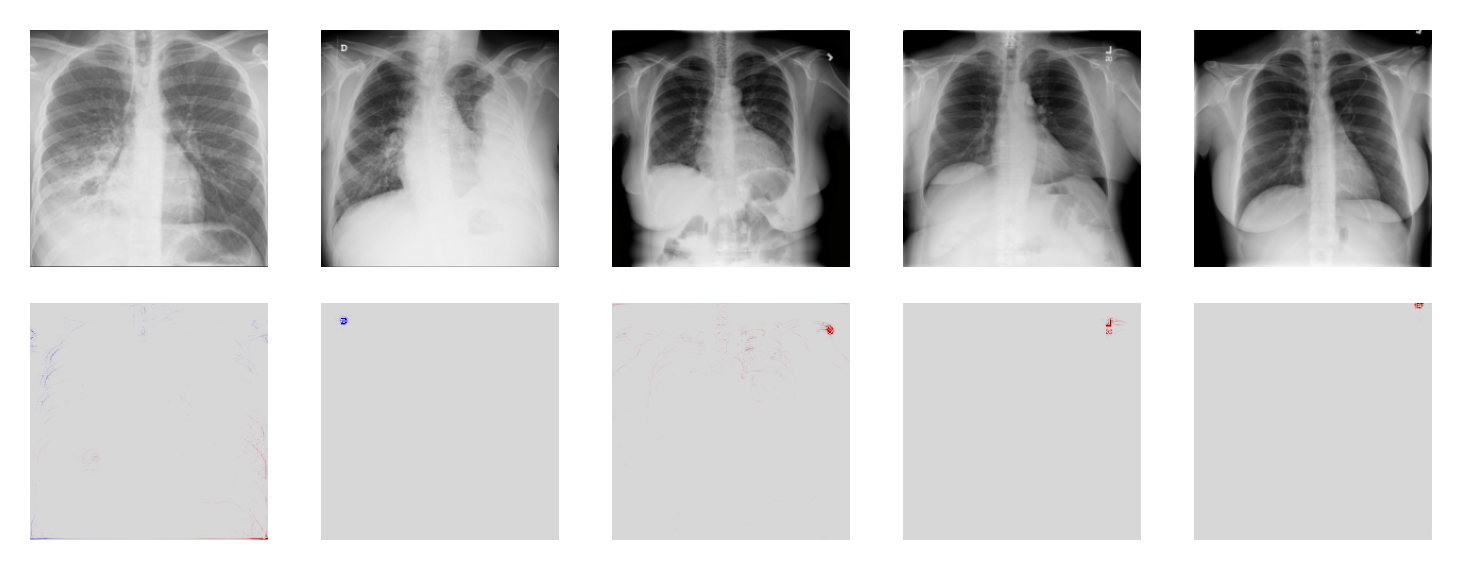

In [266]:
for I, T in zip([Ipos, Ineg], ['pos', 'neg']):
    plt.figure(figsize=(Nvis,2), dpi=300)
    for i, (x, y, y_) in enumerate(zip(Xtest[I], ytest[I], yhat[I])):
        output, attribution = explain(x.unsqueeze(0), f)
        # print(output, y.item())
        R = attribution[0].sum(0)
        
        plt.subplot(2,Nvis,i+1)
        immono(data2img(x).numpy(), filename='imgs/%s_%i_input.png'%(T,i), cmap='gray')
        plt.subplot(2,Nvis,i+Nvis+1)
        immono(R.numpy(), filename='imgs/%s_%i_heatmap.png'%(T,i))
    plt.tight_layout()
    plt.show()

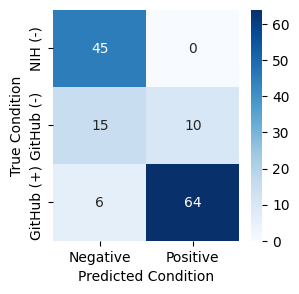

full f1  : 88.89
github f1: 88.89


In [142]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

n_nih = len(test_dataset.nih_indices)
n_cov = len(test_dataset.covid_indices)

ytest_nih = ytest[:n_nih]
ytest_covid = ytest[n_nih:]
yhat_nih = yhat[:n_nih]
yhat_covid = yhat[n_nih:]

def adjust_cm(cm):
    if cm.shape == (1, 1):
        cm = np.append(cm, np.zeros((1, 1)), axis=1)
    return cm

cm_nih = confusion_matrix(ytest_nih, yhat_nih, labels=[0,1])
cm_cov = confusion_matrix(ytest_covid, yhat_covid, labels=[0,1])

cm_ext = np.array([
    [cm_nih[0, 0], cm_nih[0, 1]],  # NIH Negative: TN, FP
    [cm_cov[0, 0], cm_cov[0, 1]],  # COVID Negative: TN, FP
    [cm_cov[1, 0], cm_cov[1, 1]]   # COVID Positive: FN, TP
], dtype=int)

def plot_confusion_matrix(cm, title='Confusion Matrix'):
    labels_row = ['NIH (-)', 'GitHub (-)', 'GitHub (+)']
    labels_col = ['Negative', 'Positive']
    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_col, yticklabels=labels_row)
    plt.ylabel('True Condition')
    plt.xlabel('Predicted Condition')
    plt.title(title)
    plt.show()

# Confusion Matrix visualisieren
plot_confusion_matrix(cm_ext, title='')

print('full f1  : %.2f'%(100*f1_score(ytest, yhat)))
print('github f1: %.2f'%(100*f1_score(ytest_covid, yhat_covid)))

In [173]:
from sklearn.metrics import accuracy_score

def compute_sample_weight(y_true):
    if isinstance(y_true, tr.Tensor):
        y_true = y_true.numpy()
    sample_weight = np.ones_like(y_true)
    sample_weight[y_true == 1] = 1 / np.mean(y_true)
    sample_weight[y_true == 0] = 1 / (1 - np.mean(y_true))
    return sample_weight

sample_weight = compute_sample_weight(ytest_covid)

print('full acc  : %.2f'%(100*accuracy_score(ytest, yhat)))
print('github acc: %f'%(100*accuracy_score(ytest_covid, yhat_covid, sample_weight=sample_weight)))

full acc  : 88.57
github acc: 75.172414


In [147]:
sample_weight, ytest_covid

(array([1, 1, 3, 3, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3,
        1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 3, 1, 1, 1, 1, 1, 3,
        1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3,
        3, 1, 1, 1, 1, 1, 3]),
 tensor([1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
         1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
         1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0]))

In [274]:
tn, fp, fn, tp = confusion_matrix(ytest, yhat).ravel()
fpr = fp / (fp + tn)
print('full fpr  : %.2f'%(100*fpr))

tn, fp, fn, tp = confusion_matrix(ytest_covid, yhat_covid).ravel()
fpr = fp / (fp + tn)
print('github fpr: %.2f'%(100*fpr))

full fpr  : 14.29
github fpr: 40.00


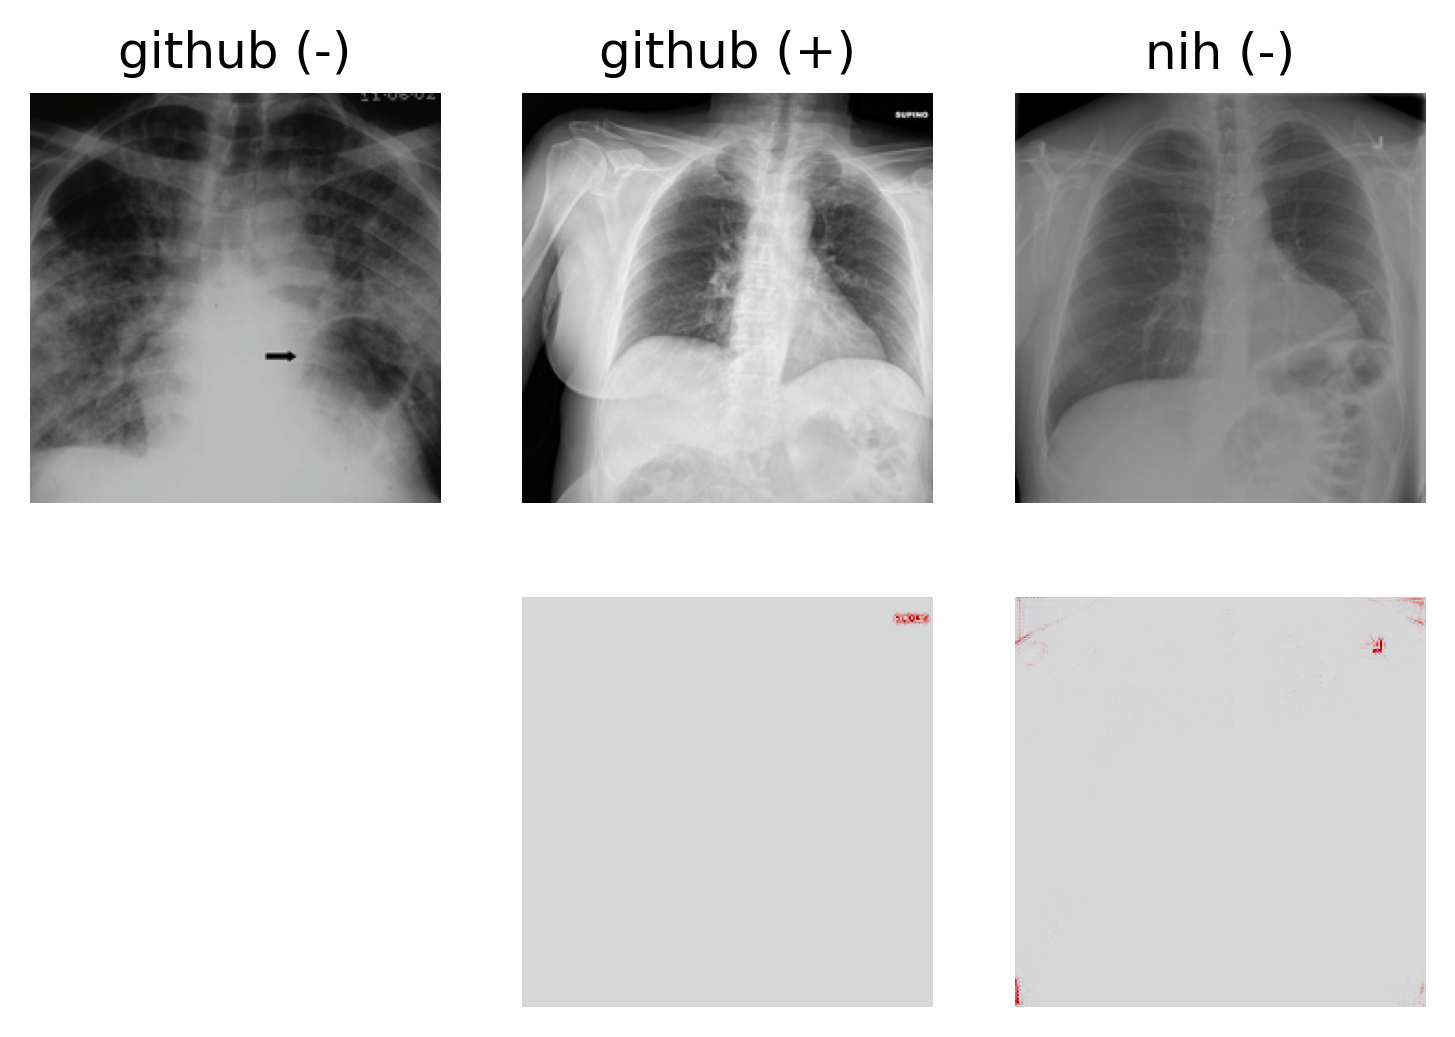

In [190]:
# pick false positives from github train data
yhat_train = clf.decision_function(Ztrain) > optimal_threshold
FP = (yhat_train == 1) * (ytrain.numpy() == 0)
is_github = (np.arange(len(ytrain)) > len(train_dataset.nih_indices))
candidates = FP * is_github
# i_z = candidates.nonzero()[0][16]
# z_github = Ztrain[i_z]
# x_ = Xtrain[i_z]

# pick one true positive from github test data
TP = (yhat == 1) * (ytest.numpy() == 1)
is_github = (np.arange(len(ytest)) > n_nih)
candidates = TP * is_github
# i_github = candidates.nonzero()[0][6]
# x_github = Xtest[i_github]
# z_github = Ztest[i_github]

# one true negative from nih test data
candidates = ~is_github
i_nih = candidates.nonzero()[0][1]
x_nih = Xtest[i_nih]
z_nih = Ztest[i_nih]

RR.append([])

plt.figure(figsize=(6,4), dpi=300)
plt.subplot(2,3,1)
plt.title('github (-)')
immono(data2img(Xtrain[i_z]).numpy(), cmap='gray')
for i, (z, x, T) in enumerate(zip([z_github, z_nih], [x_github, x_nih], ['github (+)', 'nih (-)'])):
    f.z = z
    output, attribution = explain(x[None], f)
    # print('%2d pred: %d, true: %d'%(i,attr_output(output).argmax().item(), y.item()))
    R = attribution[0].sum(0)
    RR[-1].append(R)
    plt.subplot(2,3,i+1+1)
    plt.title(T)
    immono(data2img(x).numpy(), filename='imgs/%s_%i_input.png'%(T,i), cmap='gray')
    plt.subplot(2,3,i+2+1+2)
    immono(R.numpy(), filename='imgs/%s_%i_heatmap.png'%(T,i))
    #cbar = plt.colorbar(fraction=0.046, pad=0.04)
    #cbar.ax.tick_params(labelsize=3)
# plt.tight_layout()
plt.show()

In [30]:
yhat = clf.decision_function(Ztest) > optimal_threshold
candidates = (yhat == ytest.numpy()).nonzero()[0]
RR = []
def attr_fn(fx):
    fx[:,0] = 0
    return fx
for i in candidates:
    x = Xtest[i]
    output, attribution = explain(x[None], f, attr_fn)
    R = attribution[0].sum(0)
    RR += [R]

RR = tr.stack(RR)

In [134]:
vval = tr.quantile(RR[RR > 0], .9996)
vval

tensor(6.5792)

nih negative -0.8907278914156951
nih negative -0.4963079040814092
nih negative -1.8762393118665195
nih negative -2.6036029463949246
nih negative -2.0411835713748534
nih negative -1.286584978371238
nih negative -1.5409048350432952
nih negative -1.0294017418692798
nih negative -1.30721617794615
nih negative -1.3385047603863736
nih negative -0.8549032808498733
nih negative -1.0845325000651045
nih negative -1.8292684271879487
nih negative -2.027997194366425
nih negative -1.894021962272895
nih negative -0.6797218827201423
nih negative -0.9327387048928868
nih negative -1.786334551984845
nih negative -1.723243782442639
nih negative -1.2251214337028162
nih negative -1.5885307759738327
nih negative -0.8658885608967448
nih negative -0.5778356105657343
nih negative -1.1667953623020229
nih negative -1.164876759740694
nih negative -1.8941140554739673
nih negative -2.2155432652897713
nih negative -0.8995269461237118
nih negative -1.073411096690722
nih negative -1.6880047438582941
nih negative -1.940

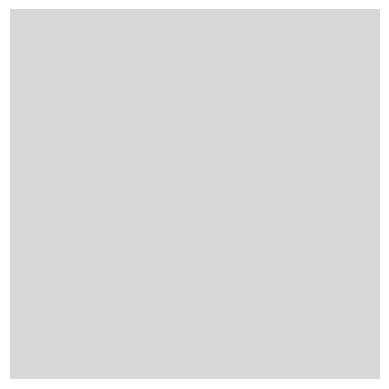

In [135]:
import scipy.ndimage

pth = "results/heatmaps/%s/%d_%s.png"
for i, j in enumerate(candidates):
    fldr = ''
    if j >= len(test_dataset.nih_indices):
        print('github ', end='')
        fldr += 'github'
    else:
        print('nih ', end='')
        fldr += 'nih'
    if ytest[j] == 1:
        print('pos ', end='')
        fldr += '_pos'
    else:
        print('negative ', end='')
        fldr += '_neg'
    print(clf.decision_function(Ztest[[j]])[0])
    x = Xtest[j]
    R = RR[i]
    #plt.subplot(121)
    immono(data2img(x).numpy(), cmap='gray', filename=pth%(fldr,j,'input'))
    #plt.subplot(122)
    immono(R.numpy(), vmin=-vval, vmax=vval, filename=pth%(fldr,j,'heatmap'))
    #plt.show()
    #plt.close()

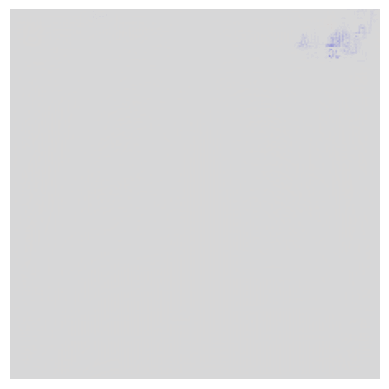

In [124]:
immono(RR[candidates < len(test_dataset.nih_indices)].mean(0), vmin=-vval, vmax=vval, filename='results/heatmaps/nih_neg.png')

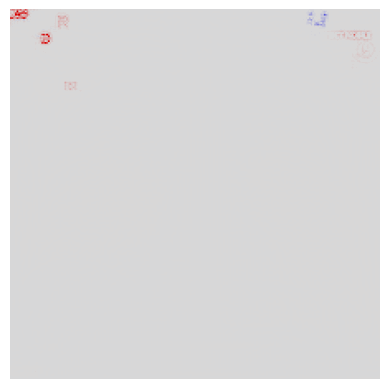

In [125]:
immono(RR[(candidates >= len(test_dataset.nih_indices)) * (ytest[candidates] == 0).numpy()].mean(0), vmin=-vval, vmax=vval, filename='results/heatmaps/github_neg.png')

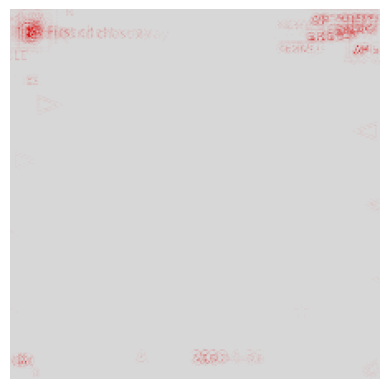

In [126]:
immono(RR[ytest[candidates] == 1].mean(0), vmin=-vval, vmax=vval, filename='results/heatmaps/github_pos.png')

In [127]:
candidates

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  54,  55,  56,  57,  58,  59,  60,  61,  63,  64,  66,  67,
        69,  70,  71,  72,  73,  76,  78,  79,  80,  81,  82,  83,  84,
        85,  86,  87,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
       101, 102, 103, 105, 106, 107, 108, 109, 111, 112, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 124, 125, 126, 127, 129, 130, 132,
       133, 134, 135, 136, 137, 138, 139])

In [128]:
((candidates >= len(test_dataset.nih_indices)) * (ytest[candidates] == 0).numpy()).sum()

15

In [140]:
len(test_dataset.nih_indices), ytest[len(test_dataset.nih_indices):].unique(return_counts=True)

(45, (tensor([0, 1]), tensor([25, 70])))